In [136]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [137]:
def get_data_and_first_cleaning():
    rooth_path = '../rawdata/training/'
    failures_df = pd.read_csv(rooth_path + 'wind-farm-1-failures-training.csv')
    locations_df = gpd.read_file(rooth_path + "wind-farm-1-locations.shp")
    logs_df = pd.read_csv(rooth_path + 'wind-farm-1-logs-training.csv')
    metmast_df = pd.read_csv(rooth_path + 'wind-farm-1-metmast-training.csv', sep=';')
    signals_df = pd.read_csv(rooth_path + 'wind-farm-1-signals-training.csv', sep=';')
    power_df = pd.read_csv(rooth_path + 'Power_curve.csv', sep=',')
    costs_df = pd.read_csv(rooth_path + 'HTW_Costs.csv')
    
    # pass all the Timestamps to date-time format and set as index
    failures_df['Timestamp'] = pd.to_datetime(failures_df['Timestamp'])
    logs_df['Timestamp'] = pd.to_datetime(logs_df['TimeDetected'])
    logs_df = logs_df.drop(columns=['TimeDetected','UnitTitleDestination'])
    metmast_df['Timestamp'] = pd.to_datetime(metmast_df['Timestamp'])
    signals_df['Timestamp'] = pd.to_datetime(signals_df['Timestamp'])
    locations_df = locations_df.drop(columns='data_set_av')
    
    # Replace by integers Turbine_ID
    failures_df.replace({'T01': 1, 'T06': 6, 'T07': 7, 'T09': 9, 'T11': 11}, inplace=True)
    logs_df.replace({'T01': 1, 'T06': 6, 'T07': 7, 'T09': 9, 'T11': 11}, inplace=True)
    signals_df.replace({'T01': 1, 'T06': 6, 'T07': 7, 'T09': 9, 'T11': 11}, inplace=True)
    locations_df.replace({'Wind Turbine 1': 1, 'Wind Turbine 6': 6, 'Wind Turbine 7': 7, 
                          'Wind Turbine 9': 9, 'Wind Turbine 11': 11}, inplace=True)
    
    # Set Timestamp Columns as Index
    failures_df.set_index('Timestamp', inplace=True)
    logs_df.set_index('Timestamp', inplace=True)
    metmast_df.set_index('Timestamp', inplace=True)
    signals_df.set_index('Timestamp', inplace=True)
    
    # Drop Columns with std=0
    drop_features_metmast = ['Anemometer1_Offset', 'Anemometer2_Freq', 'Anemometer2_Offset', 'Min_Raindetection',
                             'Avg_Raindetection', 'Anemometer1_CorrGain', 'Anemometer1_CorrOffset',
                             'Anemometer2_CorrGain', 'Anemometer2_CorrOffset', 'DistanceAirPress', 
                             'AirRessureSensorZeroOffset']
    metmast_df = metmast_df.drop(columns=drop_features_metmast)
    
    drop_features_signals = ['Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_ReactPwrGen2']
    signals_df = signals_df.drop(columns=drop_features_signals)
    
    # interpolate to fill NA
    metmast_df = metmast_df.interpolate()
    signals_df = signals_df.interpolate()
    
    return failures_df, locations_df, logs_df, metmast_df, signals_df, power_df, costs_df

In [138]:
failures_df, locations_df, logs_df, metmast_df, signals_df, power_df, costs_df = get_data_and_first_cleaning()

In [139]:
metmast_df_2016 = metmast_df.loc[metmast_df.index < '2017']
signals_df_2016 = signals_df.loc[signals_df.index < '2017']

In [140]:
signals_df_2016.shape, metmast_df_2016.shape

((260278, 80), (52697, 29))

In [141]:
#Function to merge Signals and Metmast - just year of 2016
def merge_data_frames():
    merge_signals_metmast = pd.merge_asof(signals_df_2016, metmast_df_2016, left_index=True, right_index=True)
    
    return merge_signals_metmast

In [142]:
merge_signals_metmast = merge_data_frames()

In [143]:
merge_signals_metmast

,Turbine_ID,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Max_Humidity,Avg_Humidity,Min_Precipitation,Max_Precipitation,Avg_Precipitation,Max_Raindetection,Anemometer1_Freq,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,11,1339.4,1233.3,1270.9,18.8,42.0,59,61,60,30,...,92,90.0,0.0,0.0,0.0,0,0.0499,98,99,418
2016-01-01 00:00:00+00:00,6,1270.0,1232.8,1248.5,6.8,42.0,51,52,53,30,...,92,90.0,0.0,0.0,0.0,0,0.0499,98,99,418
2016-01-01 00:00:00+00:00,1,1277.4,1226.1,1249.0,9.0,41.0,58,59,58,30,...,92,90.0,0.0,0.0,0.0,0,0.0499,98,99,418
2016-01-01 00:00:00+00:00,9,1376.7,1234.3,1272.0,24.7,40.0,58,57,58,44,...,92,90.0,0.0,0.0,0.0,0,0.0499,98,99,418
2016-01-01 00:00:00+00:00,7,1317.5,1229.5,1254.9,13.8,41.0,62,62,61,32,...,92,90.0,0.0,0.0,0.0,0,0.0499,98,99,418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:50:00+00:00,7,1402.0,1243.1,1288.6,30.8,36.0,58,58,57,47,...,67,67.0,0.0,0.0,0.0,0,0.0499,141,127,420
2016-12-31 23:50:00+00:00,9,1657.1,1319.1,1452.8,89.6,39.0,59,58,60,42,...,67,67.0,0.0,0.0,0.0,0,0.0499,141,127,420
2016-12-31 23:50:00+00:00,6,1325.6,1234.5,1268.3,20.3,39.0,54,55,55,28,...,67,67.0,0.0,0.0,0.0,0,0.0499,141,127,420


# DA

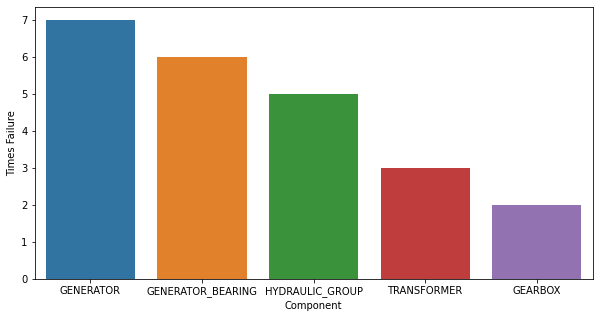

In [144]:
#Number of failures by each component
fig = plt.figure(figsize=(10,5))
nu = failures_df['Component'].value_counts().reset_index()
nu.columns = ['Component','Times Failure']
ax = sns.barplot(x='Component', y='Times Failure', data=nu)

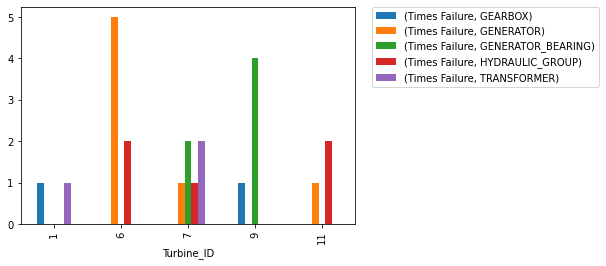

In [145]:
#Failures of components by Turbine
failures_df_by_turbine = failures_df.groupby(['Turbine_ID'])['Component'].value_counts()
failures_df_by_turbine = failures_df_by_turbine.to_frame()
failures_df_by_turbine.columns = ['Times Failure']
temp = failures_df_by_turbine.unstack()
temp.plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

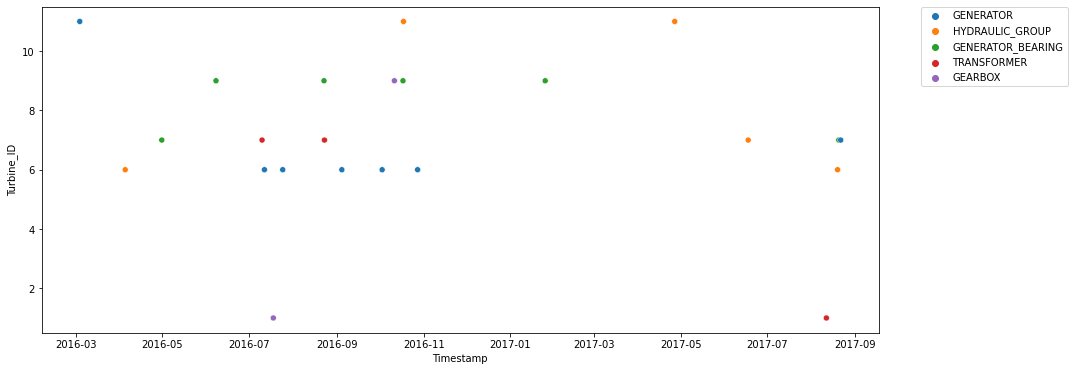

In [146]:
#Failures by component and Turbine across time
turbine_id_list = failures_df['Turbine_ID'].tolist()
component_id_list = failures_df['Component'].tolist()

fig = plt.figure(figsize=(15,6))
sns.scatterplot(x=failures_df.index, y=turbine_id_list, hue=component_id_list)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Turbine_ID')
plt.xlabel('Timestamp')
plt.show()

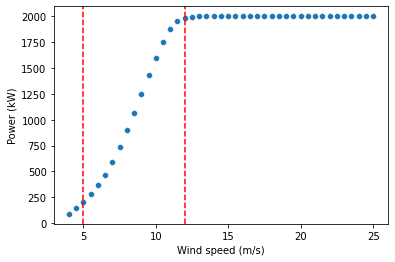

In [147]:
# Three Different phases of the turbines
sns.scatterplot(x=power_df['Wind speed (m/s)'], y=power_df['Power (kW)'])
plt.axvline(x=5, color='red', linestyle= '--')
plt.axvline(x=12, color='red', linestyle= '--')

By Research:

• Region 1: Includes the time when the turbine is starting up;

• Region 2: Operational region in which it is desirable to seize as much wind power as possible;

• Region 3: Wind speeds are relatively high (rated wind speed) and force the turbine to limit the fraction of wind power captured, for electrical and mechanical safety.

In [148]:
#Funtion to analyse by turbine
def turbine(turbine_id, df):
    new_df = df[df['Turbine_ID'] == turbine_id].sort_index(ascending=True)
    return new_df

In [149]:
# Function to find str in columns of df
def component(component, col):
    pair_comp_col=[]
    for i in col:
        if component in i:
            pair_comp_col.append(i)
    return pair_comp_col

In [150]:
# Function to analyse by component
def component_df(component, df):
    df_component = df[df['Component'] == component].sort_index(ascending=True)
    return df_component

In [151]:
#signals of each turbines
t1_df = turbine(1, signals_df)
t6_df = turbine(6, signals_df)
t7_df = turbine(7, signals_df)
t9_df = turbine(9, signals_df)
t11_df = turbine(11, signals_df)

In [152]:
#Failures of each turbines
t1_failures = turbine(1, failures_df)
t6_failures = turbine(6, failures_df)
t7_failures = turbine(7, failures_df)
t9_failures = turbine(9, failures_df)
t11_failures = turbine(11, failures_df)

In [153]:
#Failures of each component
df_generator_failures = component_df('GENERATOR', failures_df)
df_hydraulic_failures = component_df('HYDRAULIC_GROUP', failures_df)
df_bearing_failures = component_df('GENERATOR_BEARING', failures_df)
df_gearbox_failures = component_df('GEARBOX', failures_df)
df_transformer_failures = component_df('TRANSFORMER', failures_df)

### Analysing by Turbine

### T01

In [154]:
t1_df.head()

,Turbine_ID,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,1,1277.4,1226.1,1249.0,9.0,41.0,58,59,58,30,...,-144.4,0.0,-584.5,157.1,144.4,584.5,0.0,157.1,37,218.5
2016-01-01 00:10:00+00:00,1,1268.3,93.3,999.7,435.9,41.0,58,59,59,30,...,-79.6,0.0,-501.0,123.7,79.6,501.0,0.0,123.7,37,218.5
2016-01-01 00:20:00+00:00,1,1394.4,220.3,774.0,486.1,41.0,57,57,57,30,...,-314.0,0.0,-1000.0,357.4,314.0,1000.0,0.0,357.4,37,213.3
2016-01-01 00:30:00+00:00,1,1306.6,1212.4,1257.1,17.0,40.0,56,57,57,30,...,-654.0,0.0,-1000.0,245.8,654.0,1000.0,0.0,245.8,36,222.4
2016-01-01 00:40:00+00:00,1,1320.9,1224.1,1257.7,18.0,40.0,57,58,57,30,...,-496.1,0.0,-1000.0,302.7,496.1,1000.0,0.0,302.7,36,222.4


In [155]:
t1_failures

,Turbine_ID,Component,Remarks
Timestamp,,,
2016-07-18 02:10:00+00:00,1,GEARBOX,Gearbox pump damaged
2017-08-11 13:14:00+00:00,1,TRANSFORMER,Transformer fan damaged


#### No failures in Generator (component with most failures) - See behaviour

In [156]:
pair_gen = component('Gen', signals_df.columns)

In [157]:
pair_gen

['Gen_RPM_Max',
 'Gen_RPM_Min',
 'Gen_RPM_Avg',
 'Gen_RPM_Std',
 'Gen_Bear_Temp_Avg',
 'Gen_Phase1_Temp_Avg',
 'Gen_Phase2_Temp_Avg',
 'Gen_Phase3_Temp_Avg',
 'Prod_LatestAvg_ActPwrGen0',
 'Prod_LatestAvg_ActPwrGen1',
 'Prod_LatestAvg_ReactPwrGen0',
 'Prod_LatestAvg_ReactPwrGen1',
 'Gen_SlipRing_Temp_Avg',
 'Gen_Bear2_Temp_Avg']

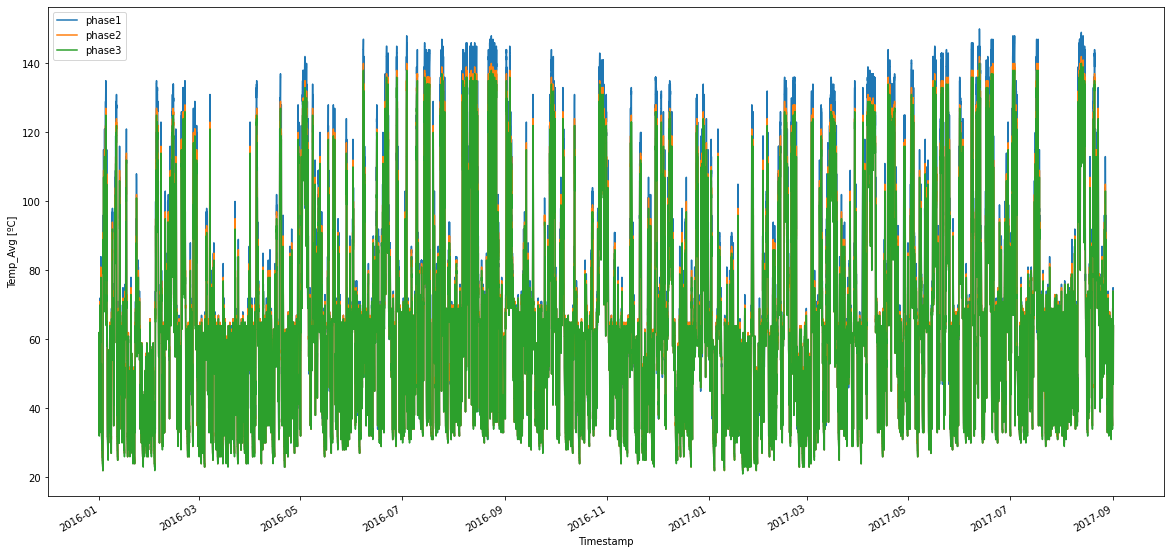

In [158]:
#TEMPERATURE
fig = plt.figure(figsize=(20,10))
t1_df.Gen_Phase1_Temp_Avg.plot(label='phase1')
t1_df.Gen_Phase2_Temp_Avg.plot(label='phase2')
t1_df.Gen_Phase3_Temp_Avg.plot(label='phase3')
plt.ylabel('Temp_Avg [ºC]')
plt.legend()
plt.show()

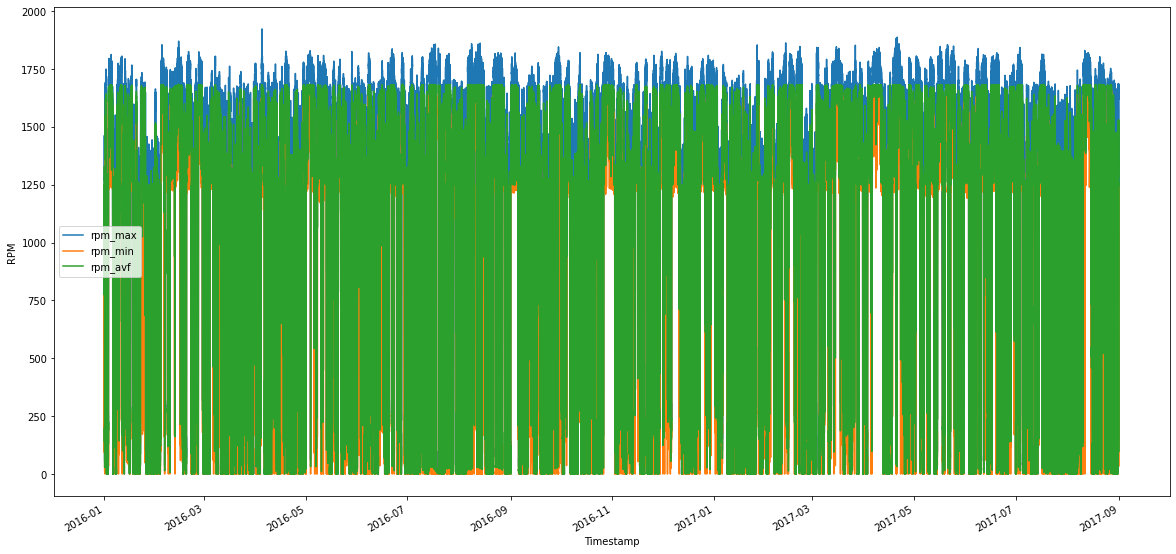

In [159]:
#RPM
fig = plt.figure(figsize=(20,10))
t1_df.Gen_RPM_Max.plot(label='rpm_max')
t1_df.Gen_RPM_Min.plot(label='rpm_min')
t1_df.Gen_RPM_Avg.plot(label='rpm_avf')
plt.ylabel('RPM')
plt.legend()
plt.show()

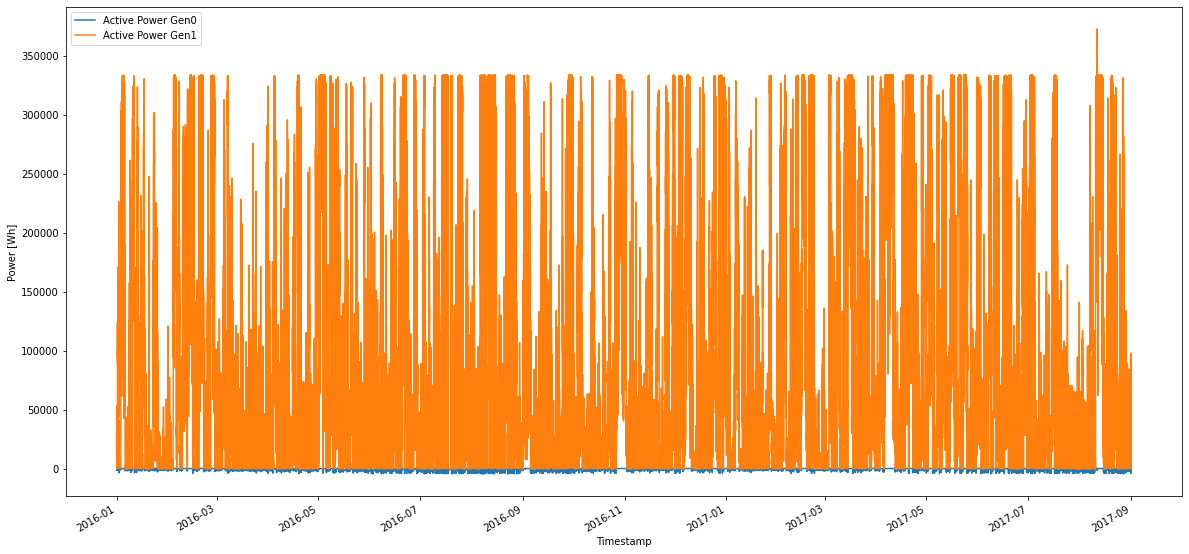

In [160]:
#POWER
fig = plt.figure(figsize=(20,10))
t1_df.Prod_LatestAvg_ActPwrGen0.plot(label='Active Power Gen0')
t1_df.Prod_LatestAvg_ActPwrGen1.plot(label='Active Power Gen1')
plt.ylabel('Power [Wh]')
plt.legend()
plt.show()

### Failures in Gearbox - See behaviour

In [161]:
pair_gear = component('Gear', signals_df.columns)
pair_gear

['Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg']

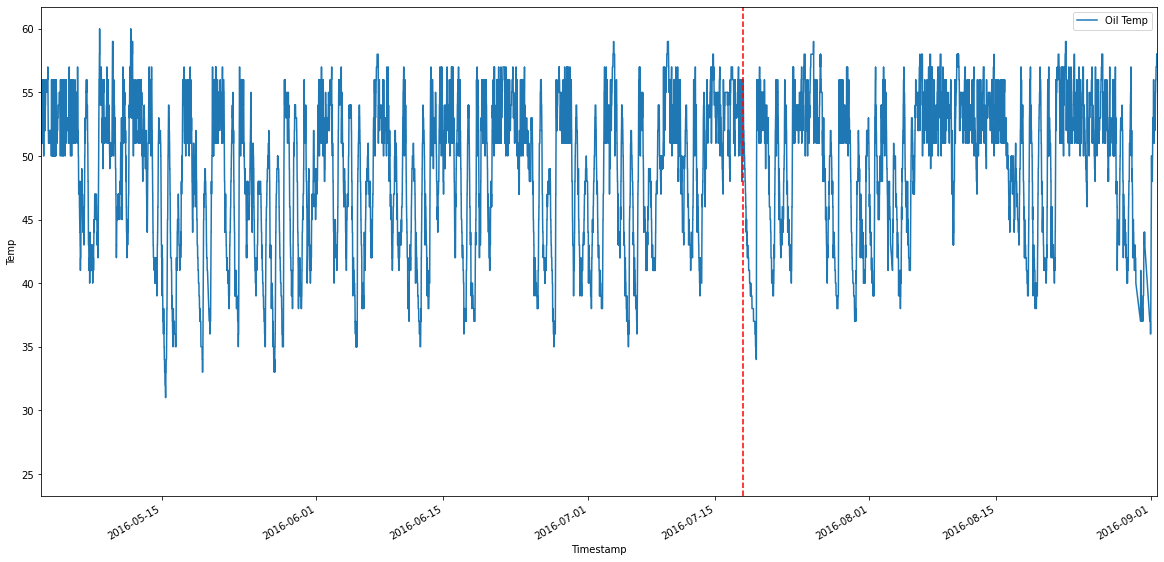

In [162]:
#TEMPERATURE and Time of Failure
fig = plt.figure(figsize=(20,10))
t1_df.Gear_Oil_Temp_Avg.plot(label='Oil Temp')
plt.ylabel('Temp')
plt.axvline(x='2016-07-18 02:10:00+00:00', color='red', linestyle= '--')
plt.xlim(('2016-05-01 16:26:00+00:00', '2016-09-01 16:26:00+00:00'))
plt.legend()
plt.show()

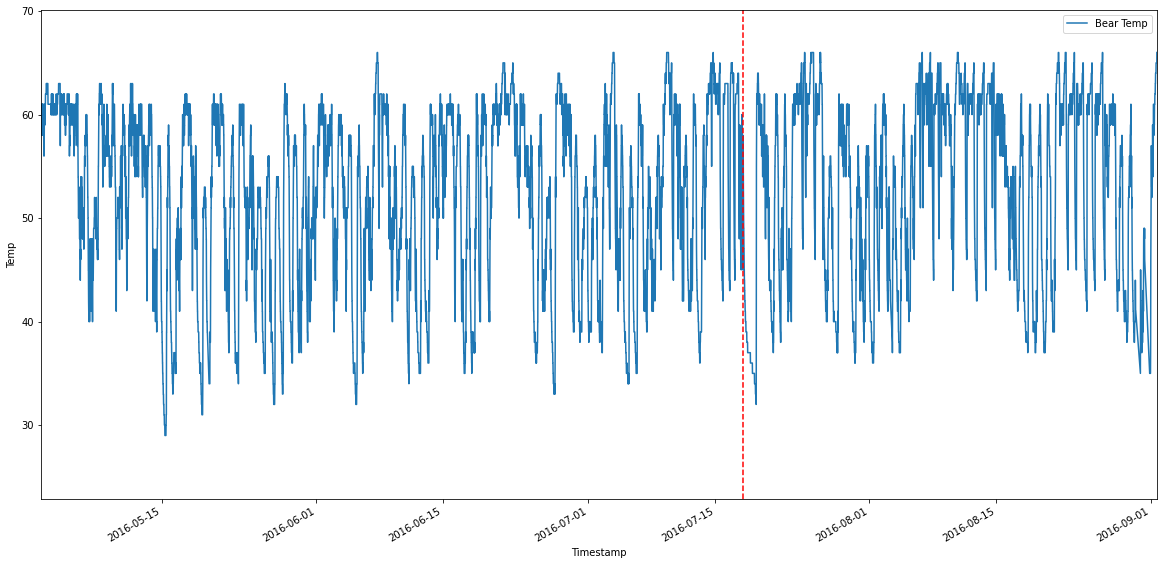

In [163]:
fig = plt.figure(figsize=(20,10))
t1_df.Gear_Bear_Temp_Avg.plot(label='Bear Temp')
plt.ylabel('Temp')
plt.axvline(x='2016-07-18 02:10:00+00:00', color='red', linestyle= '--')
plt.xlim(('2016-05-01 16:26:00+00:00', '2016-09-01 16:26:00+00:00'))
plt.legend()
plt.show()

### Failures in Transformer - See behaviour

In [164]:
pair_trafo = component('Trafo', signals_df.columns)
pair_trafo

['HVTrafo_Phase1_Temp_Avg',
 'HVTrafo_Phase2_Temp_Avg',
 'HVTrafo_Phase3_Temp_Avg']

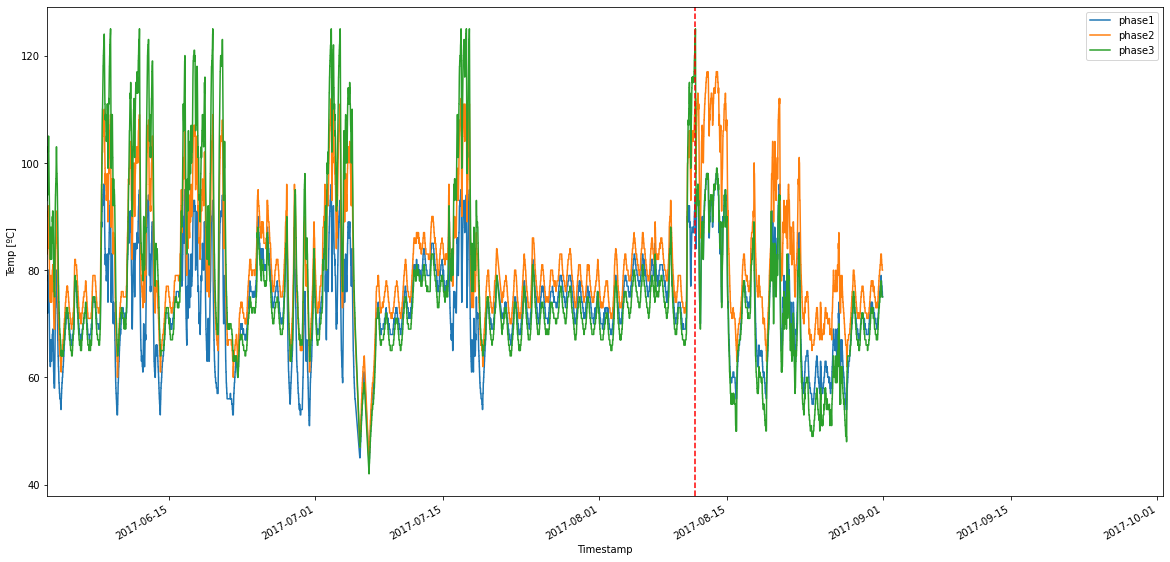

In [165]:
#Transformer
fig = plt.figure(figsize=(20,10))
t1_df.HVTrafo_Phase1_Temp_Avg.plot(label='phase1')
t1_df.HVTrafo_Phase2_Temp_Avg.plot(label='phase2')
t1_df.HVTrafo_Phase3_Temp_Avg.plot(label='phase3')
plt.axvline(x='2017-08-11 13:14:00+00:00', color='red', linestyle= '--')
plt.xlim(('2017-06-01 16:26:00+00:00', '2017-10-01 16:26:00+00:00'))
plt.ylabel('Temp [ºC]')
plt.legend()
plt.show()

### T06

In [166]:
t6_failures

,Turbine_ID,Component,Remarks
Timestamp,,,
2016-04-04 18:53:00+00:00,6,HYDRAULIC_GROUP,Error in pitch regulation
2016-07-11 19:48:00+00:00,6,GENERATOR,Generator replaced
2016-07-24 17:01:00+00:00,6,GENERATOR,Generator temperature sensor failure
2016-09-04 08:08:00+00:00,6,GENERATOR,High temperature generator error
2016-10-02 17:08:00+00:00,6,GENERATOR,Refrigeration system and temperature sensors i...
2016-10-27 16:26:00+00:00,6,GENERATOR,Generator replaced
2017-08-19 09:47:00+00:00,6,HYDRAULIC_GROUP,Oil leakage in Hub


### Failures in Generator - See behaviour

In [167]:
pair_gen = component('Gen', signals_df.columns)
pair_gen

['Gen_RPM_Max',
 'Gen_RPM_Min',
 'Gen_RPM_Avg',
 'Gen_RPM_Std',
 'Gen_Bear_Temp_Avg',
 'Gen_Phase1_Temp_Avg',
 'Gen_Phase2_Temp_Avg',
 'Gen_Phase3_Temp_Avg',
 'Prod_LatestAvg_ActPwrGen0',
 'Prod_LatestAvg_ActPwrGen1',
 'Prod_LatestAvg_ReactPwrGen0',
 'Prod_LatestAvg_ReactPwrGen1',
 'Gen_SlipRing_Temp_Avg',
 'Gen_Bear2_Temp_Avg']

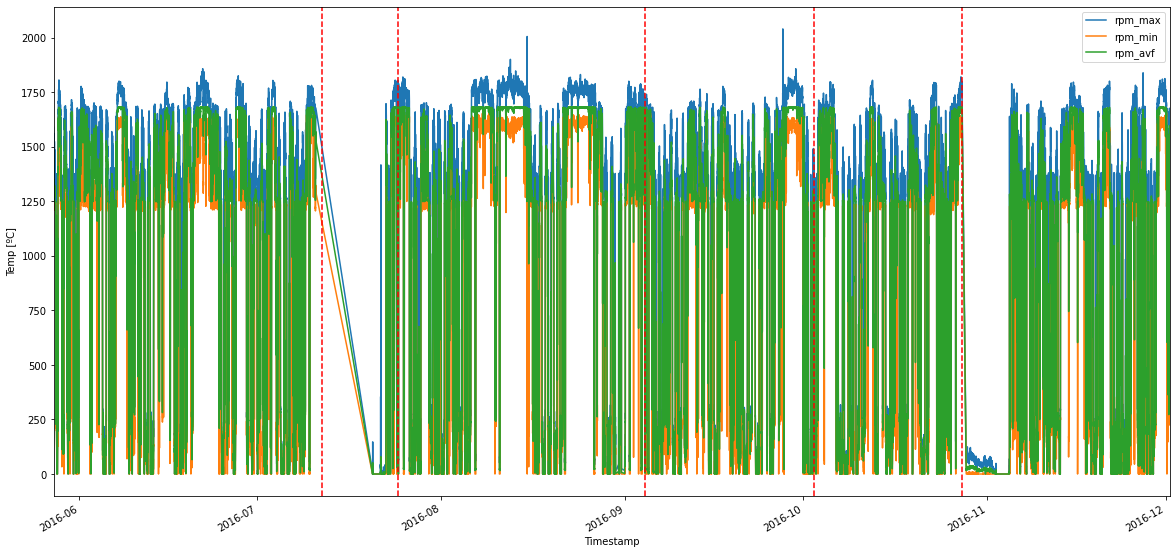

In [168]:
#RPM
fig = plt.figure(figsize=(20,10))
t6_df.Gen_RPM_Max.plot(label='rpm_max')
t6_df.Gen_RPM_Min.plot(label='rpm_min')
t6_df.Gen_RPM_Avg.plot(label='rpm_avf')
plt.axvline(x='2016-07-11 19:48:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-07-24 17:01:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-09-04 08:08:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-10-02 17:08:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-10-27 16:26:00+00:00', color='red', linestyle= '--')
plt.xlim(('2016-05-27 16:26:00+00:00', '2016-12-01 16:26:00+00:00'))
plt.ylabel('Temp [ºC]')
plt.legend()
plt.show()

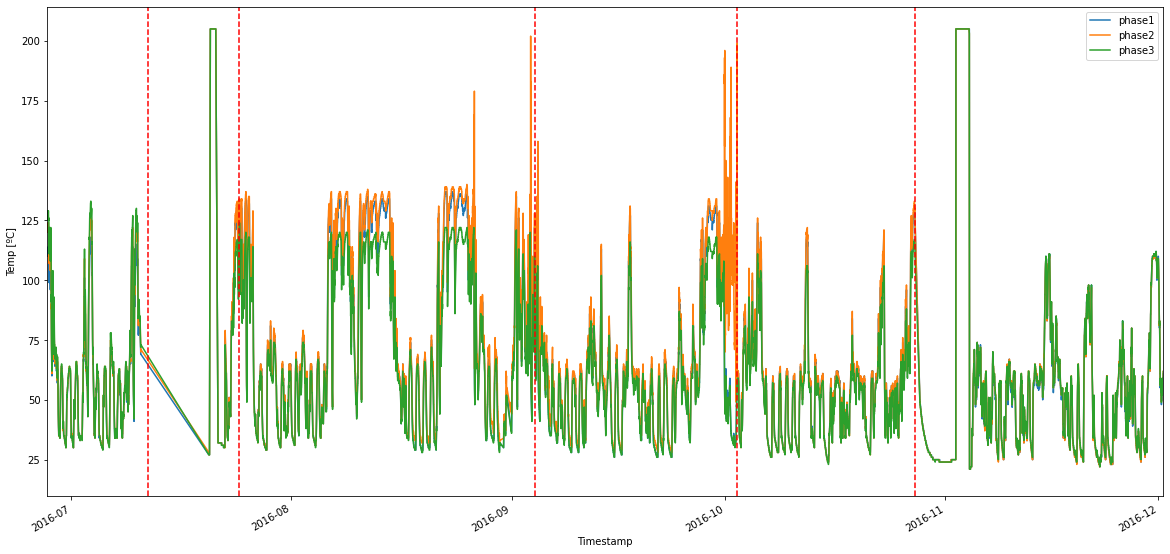

In [169]:
#Temperature
fig = plt.figure(figsize=(20,10))
t6_df.Gen_Phase1_Temp_Avg.plot(label='phase1')
t6_df.Gen_Phase2_Temp_Avg.plot(label='phase2')
t6_df.Gen_Phase3_Temp_Avg.plot(label='phase3')
plt.axvline(x='2016-07-11 19:48:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-07-24 17:01:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-09-04 08:08:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-10-02 17:08:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-10-27 16:26:00+00:00', color='red', linestyle= '--')
plt.xlim(('2016-06-27 16:26:00+00:00', '2016-12-01 16:26:00+00:00'))
plt.ylabel('Temp [ºC]')
plt.legend()
plt.show()

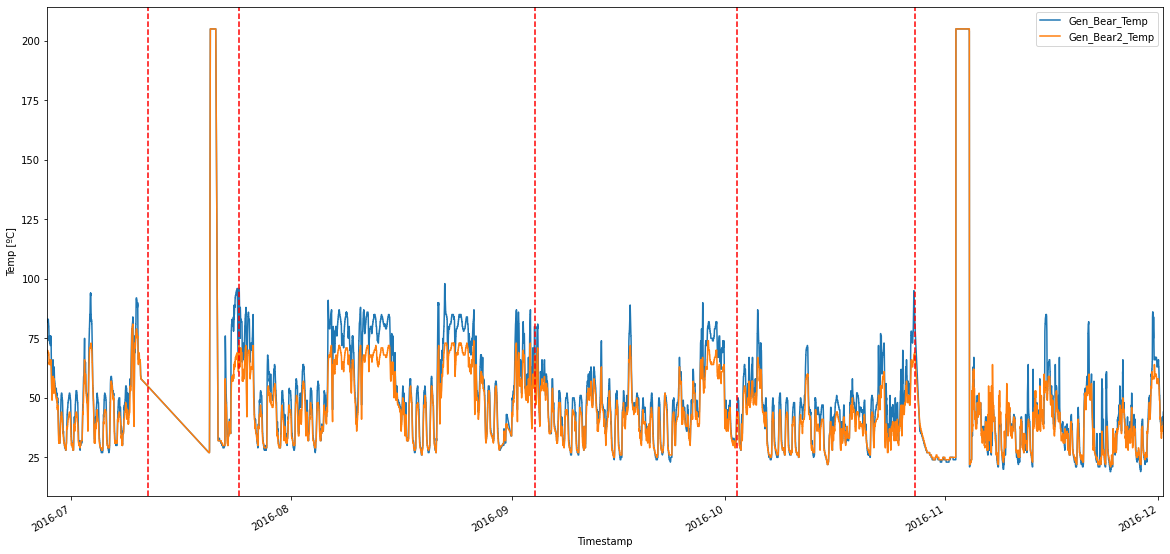

In [170]:
# Gen_Bear_Temp
fig = plt.figure(figsize=(20,10))
t6_df.Gen_Bear_Temp_Avg.plot(label='Gen_Bear_Temp')
t6_df.Gen_Bear2_Temp_Avg.plot(label='Gen_Bear2_Temp')
plt.axvline(x='2016-07-11 19:48:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-07-24 17:01:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-09-04 08:08:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-10-02 17:08:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-10-27 16:26:00+00:00', color='red', linestyle= '--')
plt.xlim(('2016-06-27 16:26:00+00:00', '2016-12-01 16:26:00+00:00'))
plt.ylabel('Temp [ºC]')
plt.legend()
plt.show()

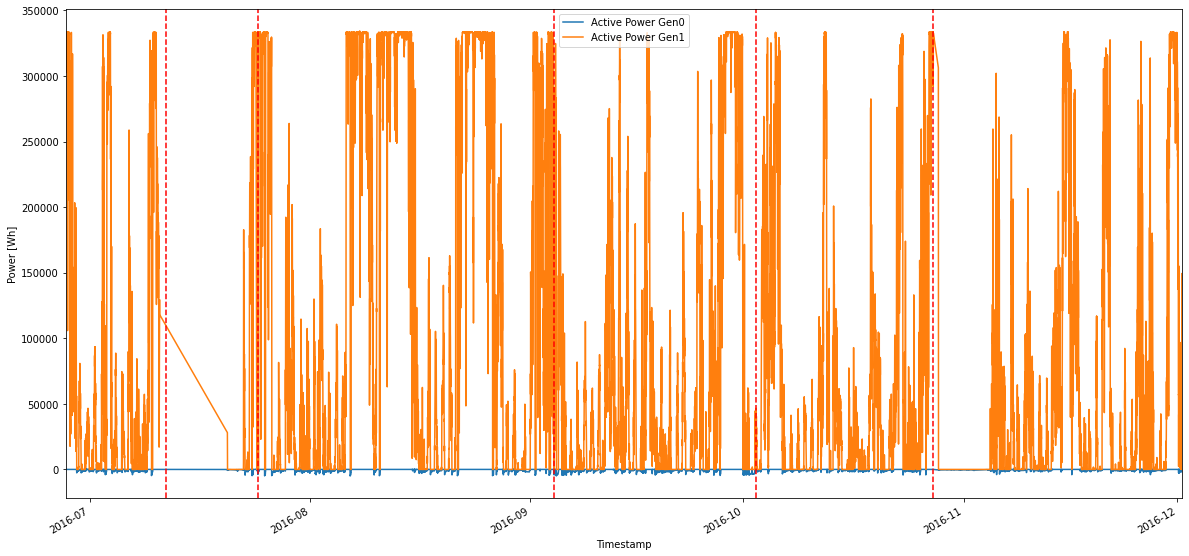

In [171]:
#ACTIVE POWER
fig = plt.figure(figsize=(20,10))
t6_df.Prod_LatestAvg_ActPwrGen0.plot(label='Active Power Gen0')
t6_df.Prod_LatestAvg_ActPwrGen1.plot(label='Active Power Gen1')
plt.axvline(x='2016-07-11 19:48:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-07-24 17:01:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-09-04 08:08:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-10-02 17:08:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-10-27 16:26:00+00:00', color='red', linestyle= '--')
plt.xlim(('2016-06-27 16:26:00+00:00', '2016-12-01 16:26:00+00:00'))
plt.ylabel('Power [Wh]')
plt.legend()
plt.show()

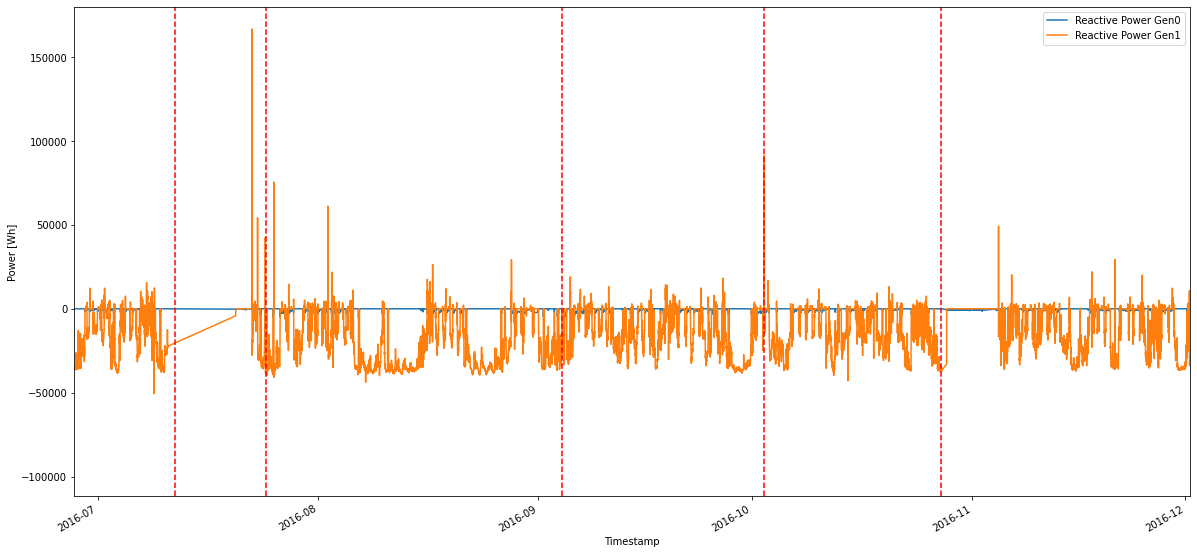

In [172]:
#REACTIVE POWER
fig = plt.figure(figsize=(20,10))
t6_df.Prod_LatestAvg_ReactPwrGen0.plot(label='Reactive Power Gen0')
t6_df.Prod_LatestAvg_ReactPwrGen1.plot(label='Reactive Power Gen1')
plt.axvline(x='2016-07-11 19:48:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-07-24 17:01:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-09-04 08:08:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-10-02 17:08:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-10-27 16:26:00+00:00', color='red', linestyle= '--')
plt.xlim(('2016-06-27 16:26:00+00:00', '2016-12-01 16:26:00+00:00'))
plt.ylabel('Power [Wh]')
plt.legend()
plt.show()

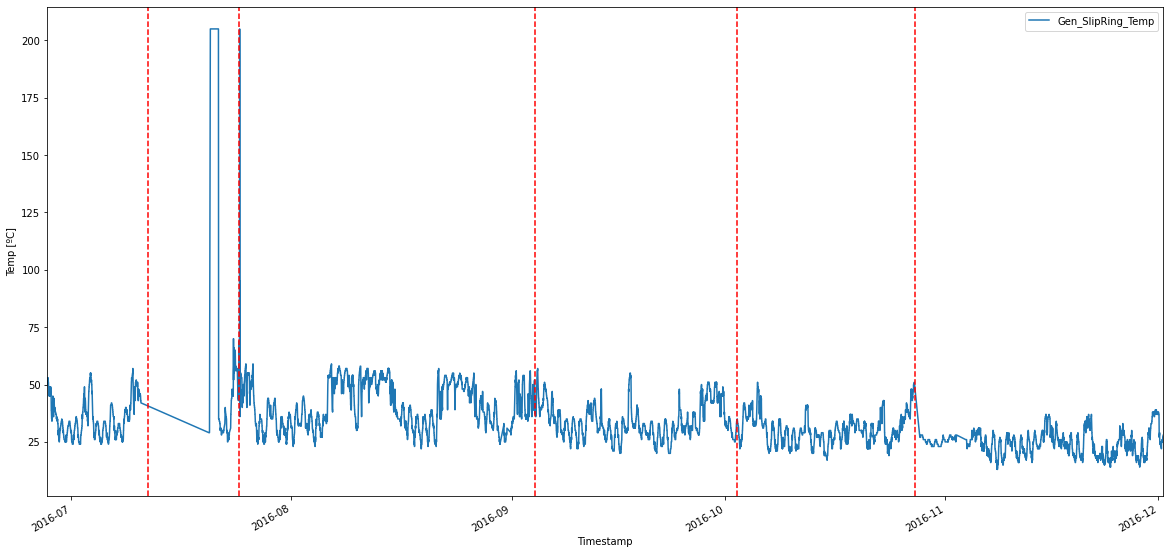

In [173]:
# Gen_SlipRing_Temp
fig = plt.figure(figsize=(20,10))
t6_df.Gen_SlipRing_Temp_Avg.plot(label='Gen_SlipRing_Temp')
plt.axvline(x='2016-07-11 19:48:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-07-24 17:01:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-09-04 08:08:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-10-02 17:08:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-10-27 16:26:00+00:00', color='red', linestyle= '--')
plt.xlim(('2016-06-27 16:26:00+00:00', '2016-12-01 16:26:00+00:00'))
plt.ylabel('Temp [ºC]')
plt.legend()
plt.show()

### Failures in Hydraulic - See behaviour

In [174]:
pair_hyd = component('Hyd', signals_df.columns)
pair_hyd

['Hyd_Oil_Temp_Avg']

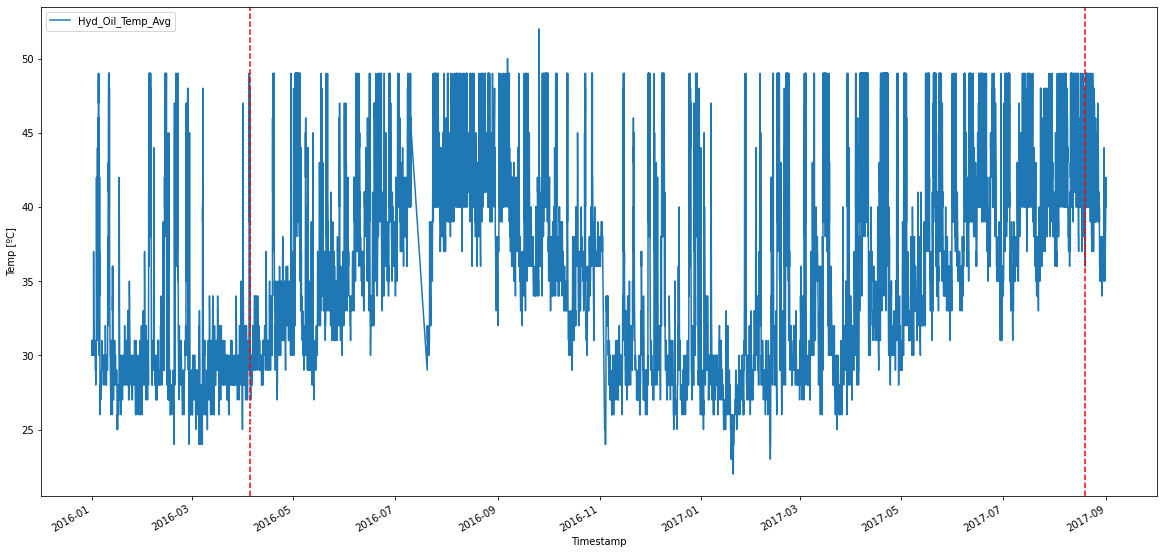

In [175]:
# Hydraulic
fig = plt.figure(figsize=(20,10))
t6_df.Hyd_Oil_Temp_Avg.plot(label='Hyd_Oil_Temp_Avg')
plt.axvline(x='2016-04-04 18:53:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2017-08-19 09:47:00+00:00', color='red', linestyle= '--')
plt.ylabel('Temp [ºC]')
plt.legend()
plt.show()

### T07

In [176]:
t7_failures

,Turbine_ID,Component,Remarks
Timestamp,,,
2016-04-30 12:40:00+00:00,7,GENERATOR_BEARING,High temperature in generator bearing (replace...
2016-07-10 03:46:00+00:00,7,TRANSFORMER,High temperature transformer
2016-08-23 02:21:00+00:00,7,TRANSFORMER,High temperature transformer. Transformer refr...
2017-06-17 11:35:00+00:00,7,HYDRAULIC_GROUP,Oil leakage in Hub
2017-08-20 06:08:00+00:00,7,GENERATOR_BEARING,Generator bearings damaged
2017-08-21 14:47:00+00:00,7,GENERATOR,Generator damaged


### Failures in Generator and Generator Bearing - See behaviour

In [177]:
pair_gen = component('Gen', signals_df.columns)
pair_gen

['Gen_RPM_Max',
 'Gen_RPM_Min',
 'Gen_RPM_Avg',
 'Gen_RPM_Std',
 'Gen_Bear_Temp_Avg',
 'Gen_Phase1_Temp_Avg',
 'Gen_Phase2_Temp_Avg',
 'Gen_Phase3_Temp_Avg',
 'Prod_LatestAvg_ActPwrGen0',
 'Prod_LatestAvg_ActPwrGen1',
 'Prod_LatestAvg_ReactPwrGen0',
 'Prod_LatestAvg_ReactPwrGen1',
 'Gen_SlipRing_Temp_Avg',
 'Gen_Bear2_Temp_Avg']

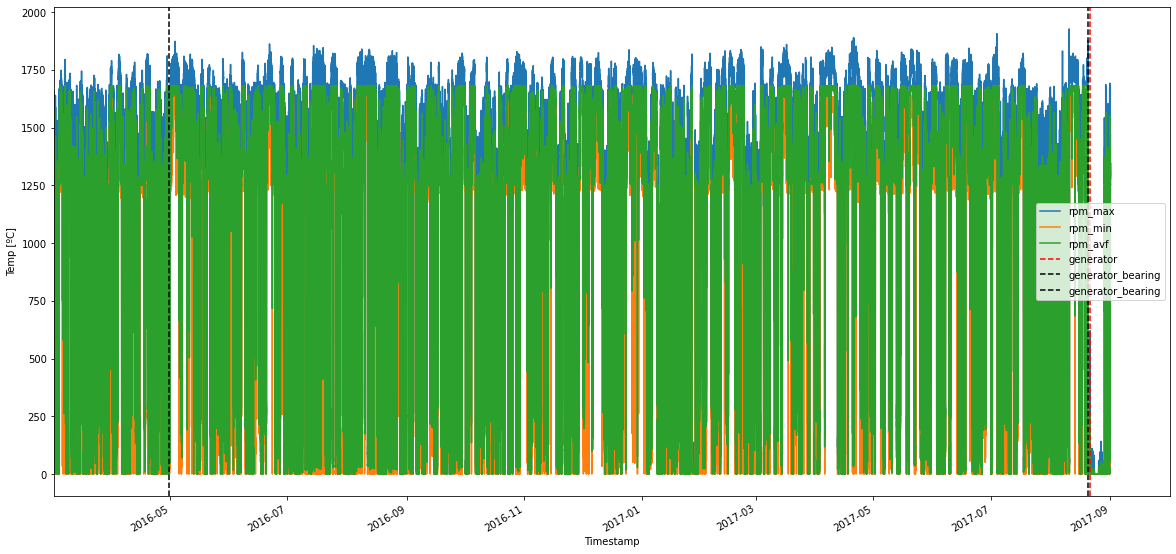

In [178]:
#RPM
fig = plt.figure(figsize=(20,10))
t7_df.Gen_RPM_Max.plot(label='rpm_max')
t7_df.Gen_RPM_Min.plot(label='rpm_min')
t7_df.Gen_RPM_Avg.plot(label='rpm_avf')
plt.axvline(x='2017-08-21 14:47:00+00:00', color='red', linestyle= '--', label='generator')
plt.axvline(x='2016-04-30 12:40:00+00:00', color='black', linestyle= '--', label='generator_bearing')
plt.axvline(x='2017-08-20 06:08:00+00:00', color='black', linestyle= '--', label='generator_bearing')
plt.xlim(('2016-03-01 16:26:00+00:00', '2017-10-01 16:26:00+00:00'))
plt.ylabel('Temp [ºC]')
plt.legend()
plt.show()

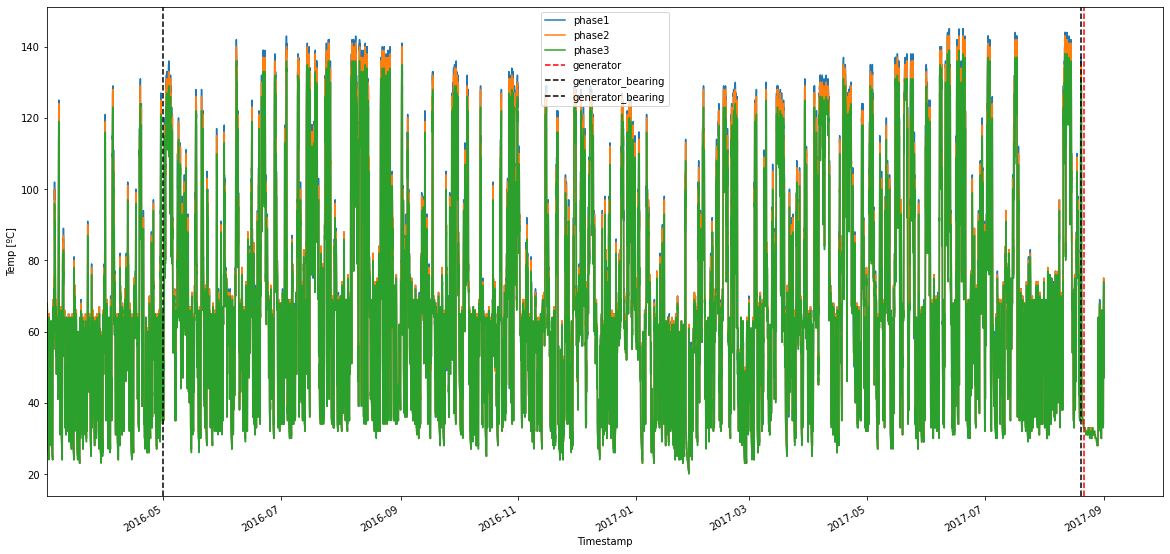

In [179]:
#Temperature
fig = plt.figure(figsize=(20,10))
t7_df.Gen_Phase1_Temp_Avg.plot(label='phase1')
t7_df.Gen_Phase2_Temp_Avg.plot(label='phase2')
t7_df.Gen_Phase3_Temp_Avg.plot(label='phase3')
plt.axvline(x='2017-08-21 14:47:00+00:00', color='red', linestyle= '--', label='generator')
plt.axvline(x='2016-04-30 12:40:00+00:00', color='black', linestyle= '--', label='generator_bearing')
plt.axvline(x='2017-08-20 06:08:00+00:00', color='black', linestyle= '--', label='generator_bearing')
plt.xlim(('2016-03-01 16:26:00+00:00', '2017-10-01 16:26:00+00:00'))
plt.ylabel('Temp [ºC]')
plt.legend()
plt.show()

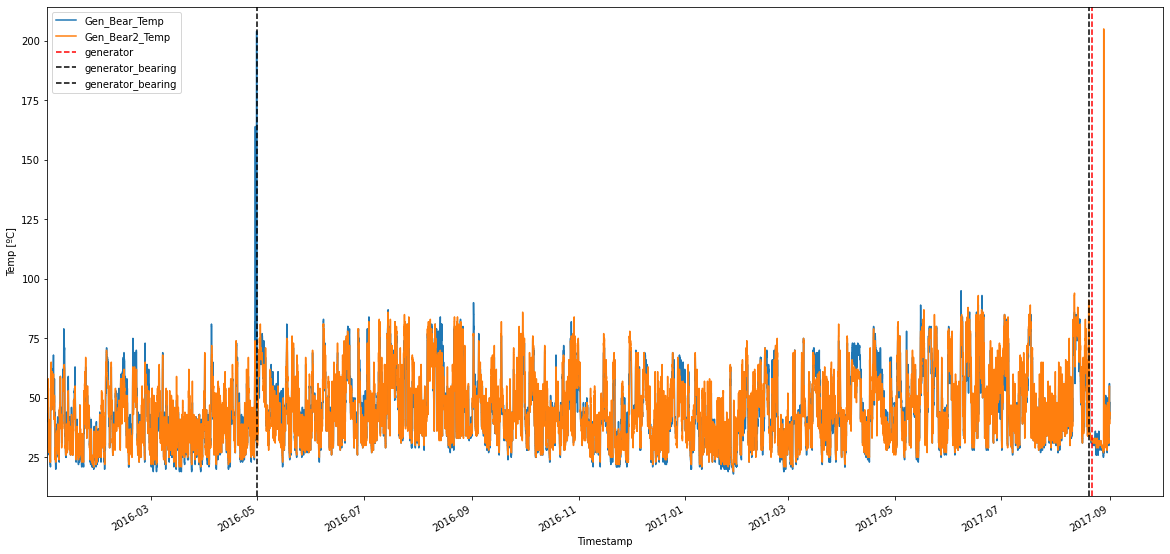

In [180]:
# Gen_Bear_Temp
fig = plt.figure(figsize=(20,10))
t7_df.Gen_Bear_Temp_Avg.plot(label='Gen_Bear_Temp')
t7_df.Gen_Bear2_Temp_Avg.plot(label='Gen_Bear2_Temp')
plt.axvline(x='2017-08-21 14:47:00+00:00', color='red', linestyle= '--', label='generator')
plt.axvline(x='2016-04-30 12:40:00+00:00', color='black', linestyle= '--', label='generator_bearing')
plt.axvline(x='2017-08-20 06:08:00+00:00', color='black', linestyle= '--', label='generator_bearing')
plt.xlim(('2016-01-01 16:26:00+00:00', '2017-10-01 16:26:00+00:00'))
plt.ylabel('Temp [ºC]')
plt.legend()
plt.show()

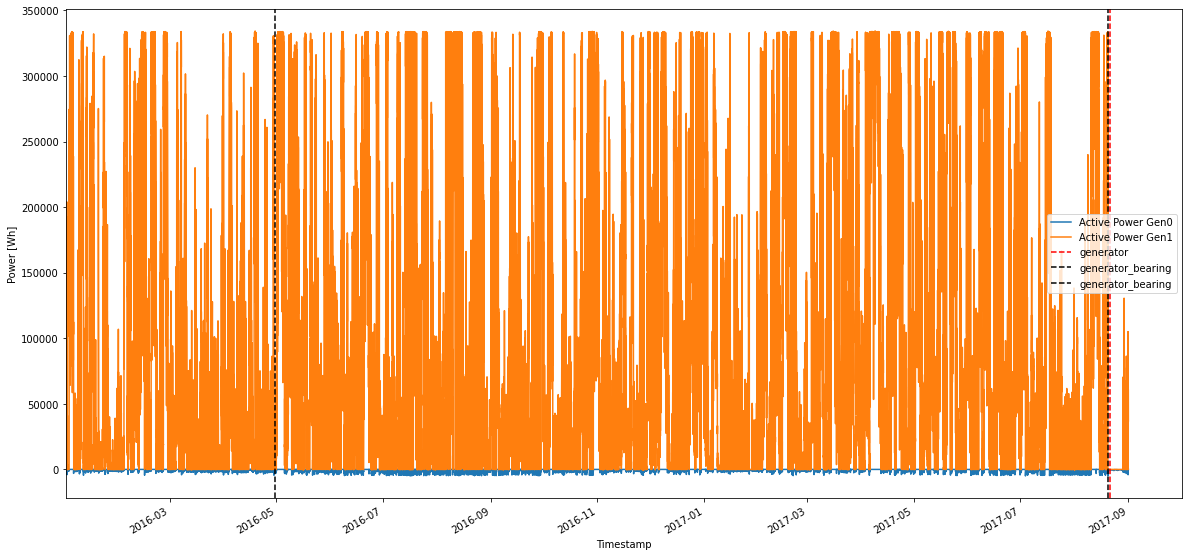

In [181]:
#ACTIVE POWER
fig = plt.figure(figsize=(20,10))
t7_df.Prod_LatestAvg_ActPwrGen0.plot(label='Active Power Gen0')
t7_df.Prod_LatestAvg_ActPwrGen1.plot(label='Active Power Gen1')
plt.axvline(x='2017-08-21 14:47:00+00:00', color='red', linestyle= '--', label='generator')
plt.axvline(x='2016-04-30 12:40:00+00:00', color='black', linestyle= '--', label='generator_bearing')
plt.axvline(x='2017-08-20 06:08:00+00:00', color='black', linestyle= '--', label='generator_bearing')
plt.xlim(('2016-01-01 16:26:00+00:00', '2017-10-01 16:26:00+00:00'))
plt.ylabel('Power [Wh]')
plt.legend()
plt.show()

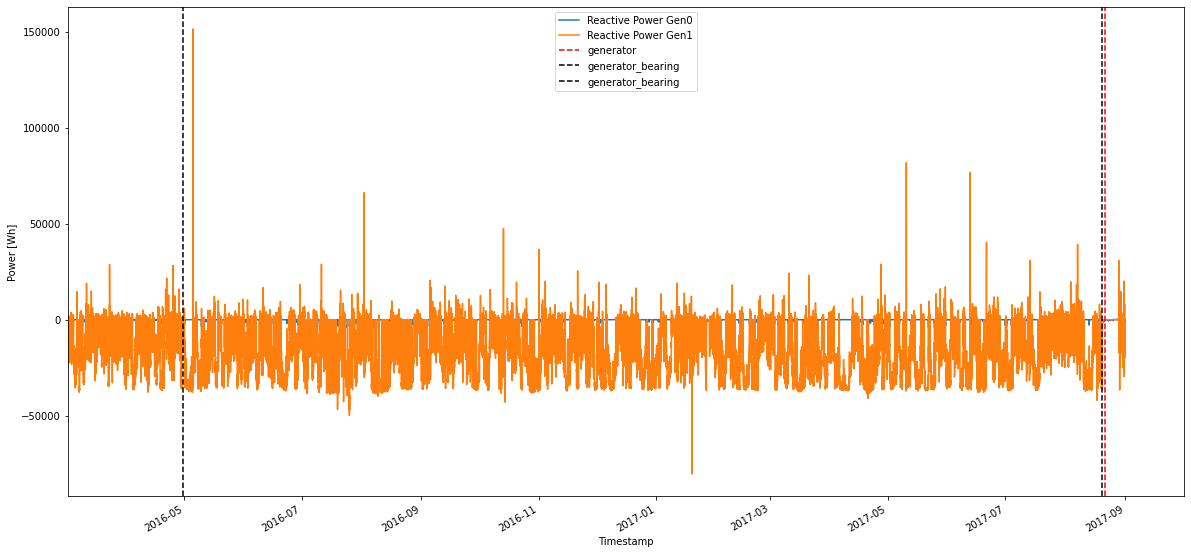

In [182]:
#REACTIVE POWER
fig = plt.figure(figsize=(20,10))
t7_df.Prod_LatestAvg_ReactPwrGen0.plot(label='Reactive Power Gen0')
t7_df.Prod_LatestAvg_ReactPwrGen1.plot(label='Reactive Power Gen1')
plt.axvline(x='2017-08-21 14:47:00+00:00', color='red', linestyle= '--', label='generator')
plt.axvline(x='2016-04-30 12:40:00+00:00', color='black', linestyle= '--', label='generator_bearing')
plt.axvline(x='2017-08-20 06:08:00+00:00', color='black', linestyle= '--', label='generator_bearing')
plt.xlim(('2016-03-01 16:26:00+00:00', '2017-10-01 16:26:00+00:00'))
plt.ylabel('Power [Wh]')
plt.legend()
plt.show()

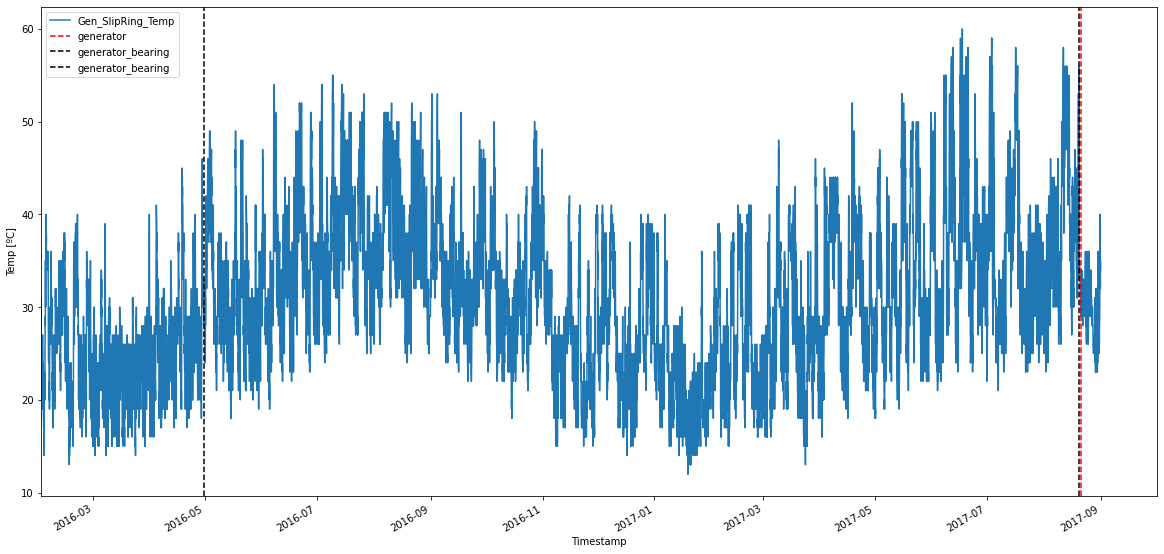

In [183]:
# Gen_SlipRing_Temp
fig = plt.figure(figsize=(20,10))
t7_df.Gen_SlipRing_Temp_Avg.plot(label='Gen_SlipRing_Temp')
plt.axvline(x='2017-08-21 14:47:00+00:00', color='red', linestyle= '--', label='generator')
plt.axvline(x='2016-04-30 12:40:00+00:00', color='black', linestyle= '--', label='generator_bearing')
plt.axvline(x='2017-08-20 06:08:00+00:00', color='black', linestyle= '--', label='generator_bearing')
plt.xlim(('2016-02-01 16:26:00+00:00', '2017-10-01 16:26:00+00:00'))
plt.ylabel('Temp [ºC]')
plt.legend()
plt.show()

### Failures in Transformer - See behaviour

In [184]:
pair_trafo = component('Trafo', signals_df.columns)
pair_trafo

['HVTrafo_Phase1_Temp_Avg',
 'HVTrafo_Phase2_Temp_Avg',
 'HVTrafo_Phase3_Temp_Avg']

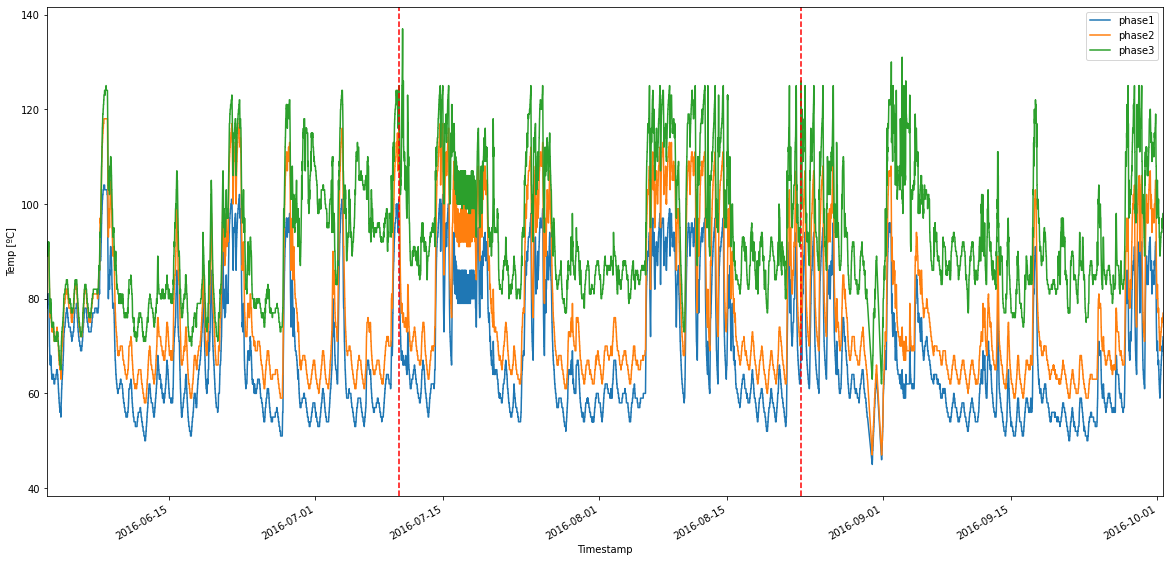

In [185]:
#Transformer
fig = plt.figure(figsize=(20,10))
t7_df.HVTrafo_Phase1_Temp_Avg.plot(label='phase1')
t7_df.HVTrafo_Phase2_Temp_Avg.plot(label='phase2')
t7_df.HVTrafo_Phase3_Temp_Avg.plot(label='phase3')
plt.axvline(x='2016-07-10 03:46:00+00:00', color='red', linestyle= '--')
plt.axvline(x='2016-08-23 02:21:00+00:00', color='red', linestyle= '--')
plt.xlim(('2016-06-01 16:26:00+00:00', '2016-10-01 16:26:00+00:00'))
plt.ylabel('Temp [ºC]')
plt.legend()
plt.show()

### Failures in Hydraulic - See behaviour

In [186]:
pair_hyd = component('Hyd', signals_df.columns)
pair_hyd

['Hyd_Oil_Temp_Avg']

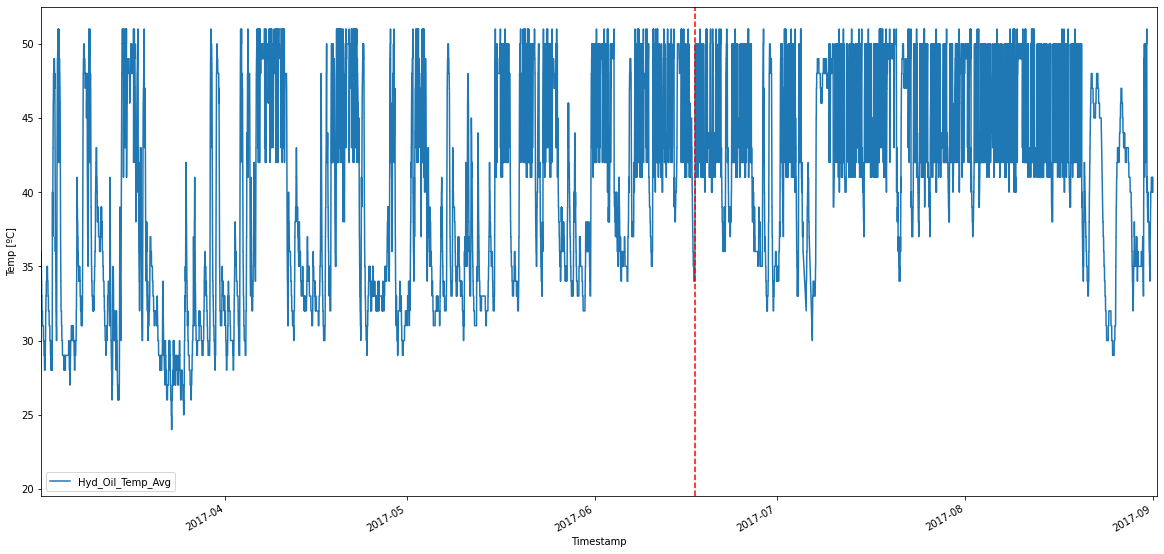

In [187]:
# Hydraulic
fig = plt.figure(figsize=(20,10))
t7_df.Hyd_Oil_Temp_Avg.plot(label='Hyd_Oil_Temp_Avg')
plt.axvline(x='2017-06-17 11:35:00+00:00', color='red', linestyle= '--')
plt.xlim(('2017-03-01 16:26:00+00:00', '2017-09-01 16:26:00+00:00'))
plt.ylabel('Temp [ºC]')
plt.legend()
plt.show()

In [188]:
t1_df.head()

,Turbine_ID,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,1,1277.4,1226.1,1249.0,9.0,41.0,58,59,58,30,...,-144.4,0.0,-584.5,157.1,144.4,584.5,0.0,157.1,37,218.5
2016-01-01 00:10:00+00:00,1,1268.3,93.3,999.7,435.9,41.0,58,59,59,30,...,-79.6,0.0,-501.0,123.7,79.6,501.0,0.0,123.7,37,218.5
2016-01-01 00:20:00+00:00,1,1394.4,220.3,774.0,486.1,41.0,57,57,57,30,...,-314.0,0.0,-1000.0,357.4,314.0,1000.0,0.0,357.4,37,213.3
2016-01-01 00:30:00+00:00,1,1306.6,1212.4,1257.1,17.0,40.0,56,57,57,30,...,-654.0,0.0,-1000.0,245.8,654.0,1000.0,0.0,245.8,36,222.4
2016-01-01 00:40:00+00:00,1,1320.9,1224.1,1257.7,18.0,40.0,57,58,57,30,...,-496.1,0.0,-1000.0,302.7,496.1,1000.0,0.0,302.7,36,222.4


In [189]:
t1_failures

,Turbine_ID,Component,Remarks
Timestamp,,,
2016-07-18 02:10:00+00:00,1,GEARBOX,Gearbox pump damaged
2017-08-11 13:14:00+00:00,1,TRANSFORMER,Transformer fan damaged


# Analysing by Component

In [190]:
# I THINK METEREOLOGICAL DF IS REDUDANT. WIND SPEED IS VERY IMPORTANT BUT IS ALSO ALREADY IN SIGNALS DF. AMB TEMP ALSO
# Let's only focus on signals_df_2016
# Create datasets for each component and label by chosing the correct input variables


# Since we don't know if the other variables are related to the failures, we will also take them in consideration
# Didn't count with "production" - output and most of "grid"
pair_rot = component('Rtr', signals_df.columns)
pair_amb = component('Amb', signals_df.columns)
pair_blds = component('Blds', signals_df.columns)
pair_cont = component('Cont', signals_df.columns)
pair_nac = component('Nac', signals_df.columns)
pair_spin = component('Spin', signals_df.columns)
pair_bus = component('Busbar', signals_df.columns)

In [191]:
temp = signals_df_2016[['Turbine_ID']]

In [192]:
df_signals_generator = signals_df_2016[pair_gen + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus]
df_signals_gen_bear = signals_df_2016[pair_gen + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus]
df_signals_transformer = signals_df_2016[pair_trafo + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus] 
df_signals_hydraulic = signals_df_2016[pair_hyd + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus] 
df_signals_gearbox = signals_df_2016[pair_gear + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus]

In [193]:
df_signals_generator['Turbine_ID'] = temp['Turbine_ID'].to_numpy()
df_signals_gen_bear['Turbine_ID'] = temp['Turbine_ID'].to_numpy()
df_signals_transformer['Turbine_ID'] = temp['Turbine_ID'].to_numpy()
df_signals_hydraulic['Turbine_ID'] = temp['Turbine_ID'].to_numpy()
df_signals_gearbox['Turbine_ID'] = temp['Turbine_ID'].to_numpy()

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [194]:
# Classification label
failures_generator = failures_df[failures_df['Component'] == 'GENERATOR']
failures_generator.replace('GENERATOR', 1, inplace=True)
failures_gen_bear = failures_df[failures_df['Component'] == 'GENERATOR_BEARING']
failures_gen_bear.replace('GENERATOR_BEARING', 1, inplace=True)
failures_hyd = failures_df[failures_df['Component'] == 'HYDRAULIC_GROUP']
failures_hyd.replace('HYDRAULIC_GROUP', 1, inplace=True)
failures_gearbox = failures_df[failures_df['Component'] == 'GEARBOX']
failures_gearbox.replace('GEARBOX', 1, inplace=True)
failures_transf = failures_df[failures_df['Component'] == 'TRANSFORMER']
failures_transf.replace('TRANSFORMER', 1, inplace=True)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/frame.py:4527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [195]:
failures_generator_2016 = failures_generator.loc[failures_generator.index < '2017']
failures_gen_bear_2016 = failures_gen_bear.loc[failures_gen_bear.index < '2017']
failures_hyd_2016 = failures_hyd.loc[failures_hyd.index < '2017']
failures_gearbox_2016 = failures_gearbox.loc[failures_gearbox.index < '2017']
failures_transf_2016 = failures_transf.loc[failures_transf.index < '2017']

In [196]:
failures_generator_2016

,Turbine_ID,Component,Remarks
Timestamp,,,
2016-03-03 19:00:00+00:00,11,1,Electric circuit error in generator
2016-07-11 19:48:00+00:00,6,1,Generator replaced
2016-07-24 17:01:00+00:00,6,1,Generator temperature sensor failure
2016-09-04 08:08:00+00:00,6,1,High temperature generator error
2016-10-02 17:08:00+00:00,6,1,Refrigeration system and temperature sensors i...
2016-10-27 16:26:00+00:00,6,1,Generator replaced


In [197]:
#Reset Index to merge df
df_signals_generator.reset_index(inplace=True)
df_signals_gen_bear.reset_index(inplace=True)
df_signals_transformer.reset_index(inplace=True)
df_signals_hydraulic.reset_index(inplace=True)
df_signals_gearbox.reset_index(inplace=True)
failures_generator_2016.reset_index(inplace=True)
failures_gen_bear_2016.reset_index(inplace=True)
failures_hyd_2016.reset_index(inplace=True)
failures_gearbox_2016.reset_index(inplace=True)
failures_transf_2016.reset_index(inplace=True)

In [198]:
#df_signals_generator_final = pd.merge_asof(df_signals_generator, failures_generator_2016, 
 #                                          left_by='Timestamp', right_by='Timestamp', on = 'Turbine_ID', 
  #                                         direction='nearest')
#df_signals_gen_bear_final = pd.merge_asof(df_signals_gen_bear, failures_gen_bear_2016, 
#                                           left_index=True, right_index=True,  left_by='Turbine_ID', right_by='Turbine_ID',
#                                          tolerance=pd.Timedelta("5m"))
#df_signals_hyd_final = pd.merge_asof(df_signals_hydraulic, failures_hyd_2016, 
#                                           left_index=True, right_index=True, by='Turbine_ID', tolerance=pd.Timedelta("1d"))
#df_signals_gearbox_final = pd.merge_asof(df_signals_gearbox, failures_gearbox_2016, 
#                                           left_index=True, right_index=True, by='Turbine_ID', tolerance=pd.Timedelta("1d"))
#df_signals_transf_final = pd.merge_asof(df_signals_transformer, failures_transf_2016, 
#                                           left_index=True, right_index=True, by='Turbine_ID', tolerance=pd.Timedelta("1d"))

##### Não estou a conseguir fazer o merge desta forma

In [199]:
#Reset Index to merge df
df_signals_generator.reset_index(inplace=True)
df_signals_gen_bear.reset_index(inplace=True)
df_signals_transformer.reset_index(inplace=True)
df_signals_hydraulic.reset_index(inplace=True)
df_signals_gearbox.reset_index(inplace=True)
failures_generator_2016.reset_index(inplace=True)
failures_gen_bear_2016.reset_index(inplace=True)
failures_hyd_2016.reset_index(inplace=True)
failures_gearbox_2016.reset_index(inplace=True)
failures_transf_2016.reset_index(inplace=True)

In [200]:
df_signals_generator_final = df_signals_generator.merge(failures_generator_2016, on=['Timestamp', 'Turbine_ID'], how='outer')
df_signals_gen_bear_final = df_signals_gen_bear.merge(failures_gen_bear_2016, on=['Timestamp', 'Turbine_ID'], how='outer')
df_signals_hyd_final = df_signals_hydraulic.merge(failures_hyd_2016, on=['Timestamp', 'Turbine_ID'], how='outer')
df_signals_gearbox_final = df_signals_gearbox.merge(failures_gearbox_2016, on=['Timestamp', 'Turbine_ID'], how='outer')
df_signals_transf_final = df_signals_transformer.merge(failures_transf_2016, on=['Timestamp', 'Turbine_ID'], how='outer')

In [201]:
#Drop Remarks, index_x, index_y Columns
df_signals_generator_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)
df_signals_gen_bear_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)
df_signals_hyd_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)
df_signals_gearbox_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)
df_signals_transf_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)

In [202]:
#Fill na on component column
df_signals_generator_final['Component'].fillna(0, inplace=True)
df_signals_gen_bear_final['Component'].fillna(0, inplace=True)
df_signals_hyd_final['Component'].fillna(0, inplace=True)
df_signals_gearbox_final['Component'].fillna(0, inplace=True)
df_signals_transf_final['Component'].fillna(0, inplace=True)

In [203]:
# Set Timestamp as Index
df_signals_generator_final.set_index('Timestamp', inplace=True)
df_signals_gen_bear_final.set_index('Timestamp', inplace=True)
df_signals_hyd_final.set_index('Timestamp', inplace=True)
df_signals_gearbox_final.set_index('Timestamp', inplace=True)
df_signals_transf_final.set_index('Timestamp', inplace=True)

In [204]:
# Sort Index
df_signals_generator_final.sort_index(inplace=True)
df_signals_gen_bear_final.sort_index(inplace=True)                                      
df_signals_hyd_final.sort_index(inplace=True)
df_signals_gearbox_final.sort_index(inplace=True)
df_signals_transf_final.sort_index(inplace=True)

In [205]:
# Fill na by interpolate
df_signals_generator_final = df_signals_generator_final.interpolate()
df_signals_gen_bear_final = df_signals_gen_bear_final.interpolate()
df_signals_hyd_final = df_signals_hyd_final.interpolate()
df_signals_gearbox_final = df_signals_gearbox_final.interpolate()
df_signals_transf_final = df_signals_transf_final.interpolate()

In [206]:
#Checking null values in DF's
print(df_signals_generator_final.isnull().values.any())
print(df_signals_gearbox_final.isnull().values.any())
print(df_signals_gen_bear_final.isnull().values.any())
print(df_signals_hyd_final.isnull().values.any())
print(df_signals_transf_final.isnull().values.any())

False
False
False
False
False


In [372]:
# DROP ROWS OF TURBINES WHERE IS NO FAILURES ASSOCIATED

# Base Model for Generator Failures 2016

In [207]:
X = df_signals_generator_final.drop(columns='Component')
y = df_signals_generator_final['Component']

In [208]:
y

Timestamp
2016-01-01 00:00:00+00:00    0.0
2016-01-01 00:00:00+00:00    0.0
2016-01-01 00:00:00+00:00    0.0
2016-01-01 00:00:00+00:00    0.0
2016-01-01 00:00:00+00:00    0.0
                            ... 
2016-12-31 23:50:00+00:00    0.0
2016-12-31 23:50:00+00:00    0.0
2016-12-31 23:50:00+00:00    0.0
2016-12-31 23:50:00+00:00    0.0
2016-12-31 23:50:00+00:00    0.0
Name: Component, Length: 260284, dtype: float64

In [209]:
### Split Train and Test
#split = int(len(X)*0.8)
#X_train, X_test = X[:split], X[split:] 
#y_train, y_test = y[:split], y[split:]

In [210]:
#Standard Scaler
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [211]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
#rnd_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [212]:
#y_pred_test = rnd_clf.predict(X_test)

In [213]:
#accuracy_score(y_test, y_pred_test)

0.9999807902875694

# Label RUL

In [214]:
# Creating DF's for Classification Problem and Regression Problem Approach
df_signals_gearbox_final.shape, df_signals_generator_final.shape, df_signals_gen_bear_final.shape, df_signals_hyd_final.shape, df_signals_transf_final.shape

((260279, 32), (260284, 44), (260281, 44), (260280, 31), (260280, 33))

In [371]:
df_signals_generator_final['Turbine_ID'].value_counts()

11    52441
7     52439
1     52433
9     52367
6     50574
Name: Turbine_ID, dtype: int64

In [216]:
df_signals_generator_final = df_signals_generator_final.groupby(by=['Timestamp','Turbine_ID']).mean()

In [217]:
df_signals_generator_final.sort_values(['Turbine_ID','Timestamp'], inplace=True)

In [249]:
#DF Signals Generator failures on turbine 6 and 11 in 2016
df_signals_generator_t6 = df_signals_generator_final[df_signals_generator_final['Turbine_ID'] == 6]
df_signals_generator_t11 = df_signals_generator_final[df_signals_generator_final['Turbine_ID'] == 11]

In [250]:
df_signals_generator_t6.loc[df_signals_generator_t6['Component'] == 1,'Timestamp']
df_signals_generator_t6 = df_signals_generator_t6.truncate(after=93898)

In [252]:
df_signals_generator_t11.loc[df_signals_generator_t11['Component'] == 1,'Timestamp']
df_signals_generator_t11 = df_signals_generator_t11.truncate(after=216852)

In [350]:
df_signals_generator_t6

,Timestamp,Turbine_ID,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Cont_Top_Temp_Avg,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Cont_VCP_ChokcoilTemp_Avg,Cont_VCP_WtrTemp_Avg,Nac_Temp_Avg,Nac_Direction_Avg,Spin_Temp_Avg,Grd_Busbar_Temp_Avg,Component
52433,2016-01-01 00:00:00+00:00,6,1270.0,1232.80,1248.5,6.8,42.0,51.0,52.0,53.0,...,38.0,28.0,38.0,96.0,38.0,29.0,204.60,20.0,37.0,0.0
52434,2016-01-01 00:10:00+00:00,6,1429.7,203.90,1154.1,271.7,42.0,51.0,52.0,52.0,...,38.0,28.0,38.0,96.0,37.0,29.0,210.50,20.0,37.0,0.0
52435,2016-01-01 00:20:00+00:00,6,1360.5,250.30,1041.4,382.7,42.0,50.0,51.0,51.0,...,38.0,27.0,38.0,93.0,39.0,29.0,199.00,20.0,37.0,0.0
52436,2016-01-01 00:30:00+00:00,6,1399.2,1228.80,1252.5,16.5,42.0,49.0,50.0,50.0,...,38.0,27.0,38.0,92.0,39.0,29.0,205.60,20.0,37.0,0.0
52437,2016-01-01 00:40:00+00:00,6,1302.7,1225.10,1257.6,13.4,41.0,50.0,50.0,51.0,...,38.0,27.0,38.0,94.0,38.0,29.0,207.40,20.0,37.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93894,2016-10-27 15:50:00+00:00,6,1798.6,1606.60,1679.9,28.2,88.0,130.0,133.0,117.0,...,54.0,33.0,51.0,136.0,42.0,40.0,100.80,27.0,56.0,0.0
93895,2016-10-27 16:00:00+00:00,6,1758.4,1614.50,1680.0,25.1,88.0,130.0,133.0,117.0,...,54.0,33.0,51.0,136.0,42.0,40.0,91.70,27.0,56.0,0.0
93896,2016-10-27 16:10:00+00:00,6,1795.0,1609.30,1681.6,25.6,88.0,130.0,133.0,117.0,...,54.0,33.0,51.0,136.0,42.0,39.0,95.20,27.0,56.0,0.0
93897,2016-10-27 16:20:00+00:00,6,1796.3,1577.80,1677.8,31.0,88.0,130.0,133.0,117.0,...,54.0,33.0,51.0,136.0,42.0,39.0,93.10,27.0,56.0,0.0


In [333]:
index_list = df_signals_generator_t6.loc[df_signals_generator_t6['Component'] == 1]

In [334]:
index_list['date'] = index_list['Timestamp']

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [339]:
index_list = index_list[['Timestamp','date']]

In [351]:
df = df_signals_generator_t6.merge(index_list, on=['Timestamp'], how='left')

In [353]:
df_generator_t6 = df.fillna(method='bfill')

In [354]:
df_generator_t6['TTF'] = df_generator_t6['date'] - df_generator_t6['Timestamp'] 

In [357]:
df_generator_t6 = df_generator_t6.drop(columns='date')

In [360]:
index_list_t11 = df_signals_generator_t11.loc[df_signals_generator_t11['Component'] == 1]

In [361]:
index_list_t11['date'] = index_list_t11['Timestamp']

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [362]:
index_list_t11 = index_list_t11[['Timestamp','date']]

In [363]:
df = df_signals_generator_t11.merge(index_list_t11, on=['Timestamp'], how='left')

In [364]:
df_generator_t11 = df.fillna(method='bfill')

In [365]:
df_generator_t11['TTF'] = df_generator_t11['date'] - df_generator_t11['Timestamp'] 

In [366]:
df_generator_t11 = df_generator_t11.drop(columns='date')

In [368]:
df_generator_t11.shape, df_generator_t6.shape

((9040, 46), (41466, 46))